# Example: Training a GapNet

This tutorial gives an overview of how to use GapNet.

GapNet is an alternative deep-learning training approach that can use highly incomplete datasets.

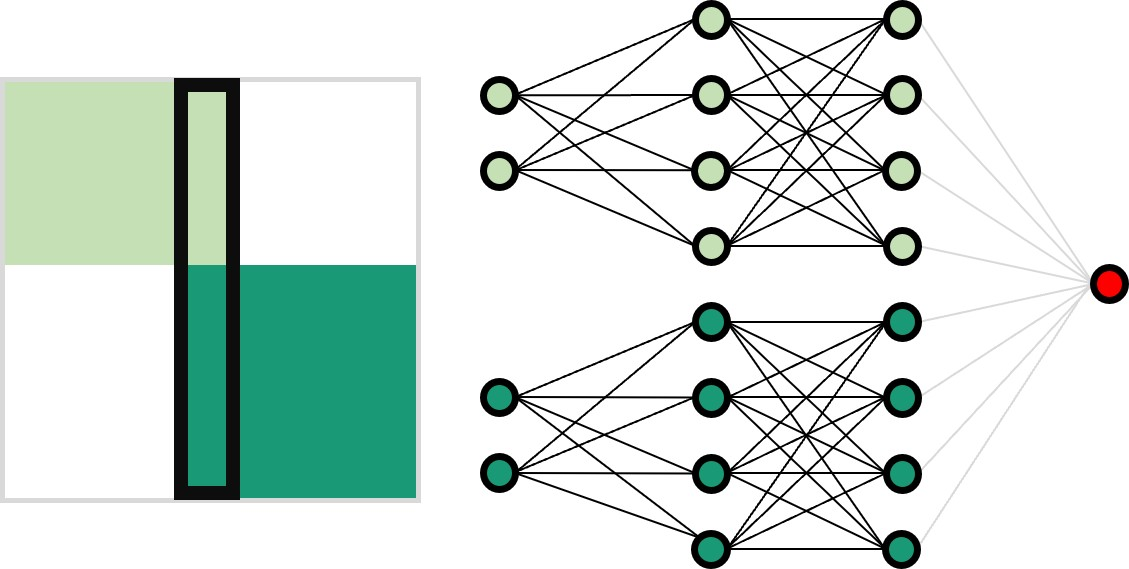

In [1]:
# Architecture of the GapNet
from IPython.display import Image
Image("./assets/GapNet.jpg", width = 500) # change the path accordingly

The figure shows a schematic representation of the dataset (on the left) and the GapNet approach (on the right) where the training takes place in two stages, where the connectors in black are trained in the first stage and the connectors in gray are trained in the second one.

## Initialization

FIrst of all we load the main GapNet functions

In [2]:
from src import gapnet as gapnet
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import isnan, load
import numpy as np

## Loading the dataset

We provide an example dataset adapted from the the simulated dataset [Madelon](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html?highlight=madelon). We provide two files: one including the inputs "X.npy" and one with the targets "y.npy".

The dataset consists of 1000 subjects of which only 100 have all 40 features. 

In [3]:
# load dataset and fill in missing values
from numpy import load

X = load('data/X.npy') 
Y = load('data/Y.npy')

print("Number of features {}".format(X.shape[1]))
print("Number of subjects {}".format(X.shape[0]))

print("\nA small example extracted from the data:")
print( X[:5,23:28] ) 

Number of features 40
Number of subjects 1000

A small example extracted from the data:
[[        nan         nan -2.3370457  -1.7468469   2.10219155]
 [        nan         nan  6.14349623 -0.2810281   0.75698303]
 [        nan         nan  3.29823735 -3.03532226 -1.78264342]
 [        nan         nan  2.75456704 -4.02496345 -0.11921146]
 [        nan         nan  6.37691339 -2.13172875  0.41432343]]


## Isolating the complete dataset

In [4]:
# The dataset with complete data
from numpy import isnan

X_overlap = X[~isnan(X).any(axis=1)]
y_overlap = Y[~isnan(X).any(axis=1)]

print("The overlapping dataset includes {} subjects"
      .format(X_overlap.shape[0]))

print("\nA small example extracted from the data:")
print( X_overlap[:5,23:28] ) 

The overlapping dataset includes 100 subjects

A small example extracted from the data:
[[-1.18462433  1.65036161  0.87117063 -1.15532245 -0.74911545]
 [-1.16066826 -4.38945709 -1.23622456 -0.70914043  0.01814909]
 [-1.04278975 -1.63331265  6.18392731 -1.55404928  0.49673932]
 [-2.01231828  0.39318088 -0.01828944 -1.70806888 -0.80552165]
 [-1.02669049 -5.80272934  0.77905295  0.47869787  0.69002946]]


## Generate the GapNet architecture


Now, it is possible to build and train the GapNet. 

It requires first of all to define an object that will include all GapNet elements, and is defined as      
*gapnet_object = gapnet.generate_gapnet_model()*

Afterwards, the build_model function is required to introduce the GapNet neural network architecture.     
*gapnet_object.build_model()*


At this point, the GapNet is ready to be trained over the two stages, using the functions train_first_stage and train_second_stage, that take as inputs the training and validation sets.   
*gapnet_model.train_first_stage(X_train, y_train, X_val, y_val)*                
*gapnet_model.train_second_stage(X_train, y_train, X_val, y_val)*

In [5]:
gapnet_model = gapnet.generate_gapnet_model(cluster_sizes = [25,15],
                                            n_feature = X.shape[1])
gapnet_model.build_model(show_summary=True, n_dense = 2)

Generating the 1 neural network model ... 
Generating the 2 neural network model ... 
Generating the final GapNet model ... 
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 50)           1300        ['input_3[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 30)           480         ['i

## Train the GapNet model

In this example, we train the GapNet num_trials times with random splitting of training and validation data. 

In [6]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_overlap, Y_overlap, X_incomplete, Y_incomplete = gapnet.separate_missing_data(X, Y)
fold = 1

for train_index, test_index in skf.split(X_overlap, Y_overlap):
    X_train, X_test = X_overlap[train_index], X_overlap[test_index]
    Y_train, Y_test = Y_overlap[train_index], Y_overlap[test_index]
    
    # train GapNet
    X_train_gapnet, X_test_gapnet, X_train_overall, \
    Y_train_overall = gapnet.preprocess_standardization_with_missing_data(X_train,
                                                                          Y_train,
                                                                          X_test,
                                                                          X_incomplete,
                                                                          Y_incomplete)
    gapnet_model.train_first_stage(X_train_overall, Y_train_overall, X_test_gapnet, Y_test)
    gapnet_model.train_second_stage(X_train_gapnet, Y_train, X_test_gapnet, Y_test)
    
    print(fold, ' fold(s) finished')
    fold+=1

Training process of first stage of GapNet is done.
Training process of second stage of GapNet is done.
1  fold(s) finished
Training process of first stage of GapNet is done.
Training process of second stage of GapNet is done.
2  fold(s) finished
Training process of first stage of GapNet is done.
Training process of second stage of GapNet is done.
3  fold(s) finished
Training process of first stage of GapNet is done.
Training process of second stage of GapNet is done.
4  fold(s) finished
Training process of first stage of GapNet is done.
Training process of second stage of GapNet is done.
5  fold(s) finished


At the end of the training process, we can evaluate the performance of the GapNet using the *present_results* function.

In [7]:
gapnet.present_results(gapnet_model)

Results :
train_accuracy 1.000+/-0.000 : [1. 1. 1. 1. 1.]
test_accuracy 0.900+/-0.105 : [0.7  0.9  0.95 0.95 1.  ]
test_auc 0.958+/-0.071 : [0.818 0.97  1.    1.    1.   ]
test_sens 0.895+/-0.122 : [0.667 0.9   0.909 1.    1.   ]
test_spec 0.907+/-0.100 : [0.727 0.9   1.    0.909 1.   ]
test_prec 0.893+/-0.122 : [0.667 0.9   1.    0.9   1.   ]


## Plot the results

After training the GapNet, it is possible to show the results by plotting the ROC curve, the confusion matrix, the loss, precision and recall functions along the training.

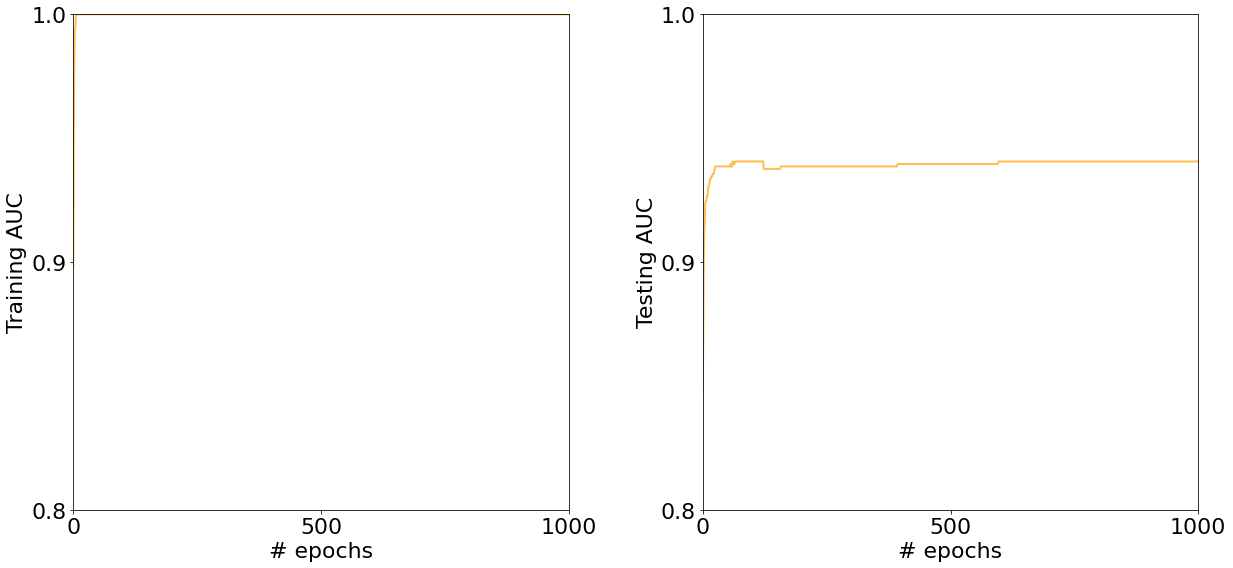

In [15]:
fig, axes = plt.subplots(1,2,figsize=(18, 8))
gapnet.plot_auc_metrics('GapNet',
                        gapnet_model.histories,
                        axes = axes[0], 
                        color='orange', 
                        ylolim = 0.8, 
                        training = True, 
                        alpha=0.15)
gapnet.plot_auc_metrics('GapNet', 
                        gapnet_model.histories, 
                        axes = axes[1], 
                        color='orange', 
                        ylolim = 0.8, 
                        training = False, 
                        alpha=0.15)
plt.tight_layout()
plt.subplots_adjust(left=None,
                    right=None,
                    bottom=None, 
                    top=None,
                    wspace=0.1, 
                    hspace=0.1)

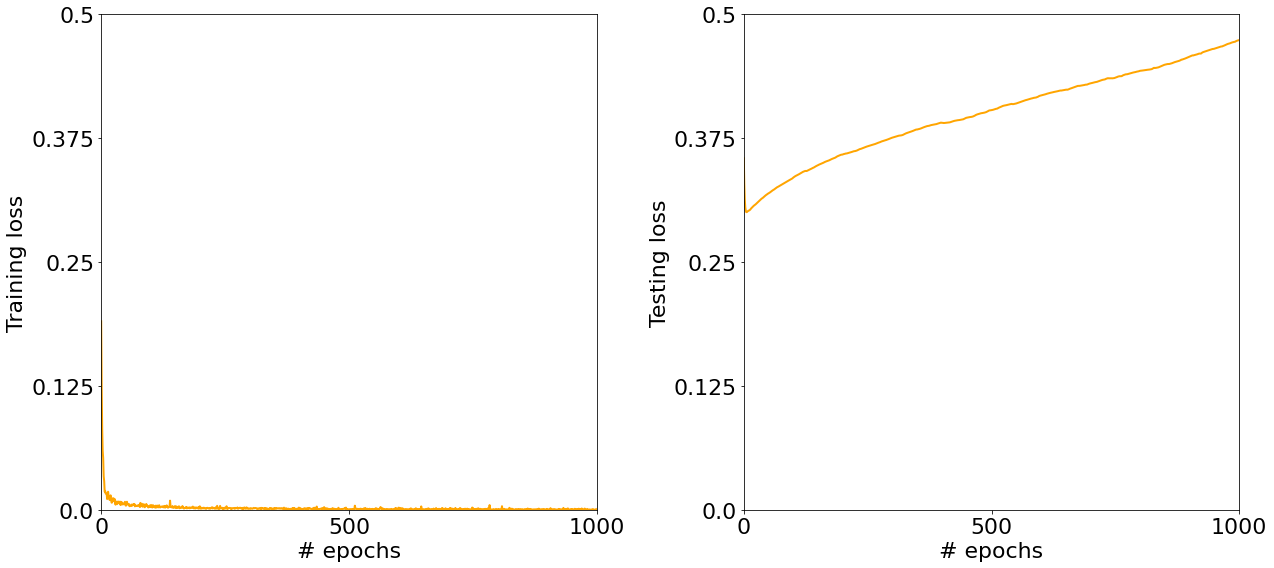

In [9]:
fig, axes = plt.subplots(1,2,figsize=(18, 8))
gapnet.plot_loss_metrics('GapNet',
                         gapnet_model.histories,
                         axes = axes[0],
                         training = True,
                         color='orange', 
                         yhilim = 0.5,
                         alpha=0.15)
gapnet.plot_loss_metrics('GapNet',
                         gapnet_model.histories, 
                         axes = axes[1], 
                         training = False,
                         color='orange',
                         yhilim = 0.5,
                         alpha=0.15)
plt.tight_layout()

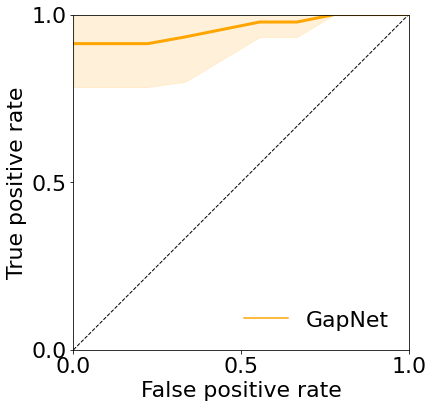

In [10]:
fig, axe = plt.subplots(1,1,figsize=(6, 6))
axe.plot(0,0.7, color= "orange", label = "GapNet")
gapnet.plot_roc("GapNet",
                gapnet_model.val_y_labels,
                gapnet_model.val_y_preds,
                axe=axe, 
                linestyle='solid',
                color='orange',
                x_label=True, 
                alpha=0.15, 
                shaded=True)
axe.legend(loc = 4, frameon=False, fontsize = 22, title_fontsize = 22)
plt.tight_layout()